**Cell 1**:
- **Data Loading and Verification**: I begin by loading tweet and bill datasets, including their respective PCA-reduced embeddings and sentiment tensors. This step ensures that the data is correctly loaded and shapes match expectations, which is crucial for subsequent operations.

In [1]:
import pandas as pd
import torch
import numpy as np
from torch_geometric.data import HeteroData
from sklearn.metrics.pairwise import cosine_similarity

# Load tweet data
tweets_df = pd.read_csv('TweetData/final_tweets.csv')
tweet_embeddings_pca = np.load('TweetData/roberta_tweets_embeddings_pca.npy')
tweet_sentiments_tensor = torch.load(
    'TweetData/roberta_tweets_sentiments_tensor.pt')

# Load bill data
bills_df = pd.read_csv('BillData/final_bills.csv')
bill_embeddings_pca = np.load('BillData/roberta_bills_embeddings_pca.npy')

# Verify loaded data shapes
print("Tweets DataFrame Shape:", tweets_df.shape)
print("Bills DataFrame Shape:", bills_df.shape)
print("Tweet Embeddings PCA Shape:", tweet_embeddings_pca.shape)
print("Tweet Sentiments Tensor Shape:", tweet_sentiments_tensor.shape)
print("Bill Embeddings PCA Shape:", bill_embeddings_pca.shape)

Tweets DataFrame Shape: (1174, 9)
Bills DataFrame Shape: (413, 10)
Tweet Embeddings PCA Shape: (1174, 293)
Tweet Sentiments Tensor Shape: torch.Size([1174, 3])
Bill Embeddings PCA Shape: (413, 171)


**Cell 2**:
- **Standardizing Embeddings**: I standardize the dimensionality of tweet embeddings to match the bill embeddings using PCA. This harmonizes the feature space dimensions across both datasets, ensuring consistent input to the graph model.

In [2]:
from sklearn.decomposition import PCA

# Set the number of PCA components
n_components = 171

# Apply PCA to tweet embeddings
pca_tweet = PCA(n_components=n_components)
tweet_embeddings_pca_standardized = pca_tweet.fit_transform(
    tweet_embeddings_pca)

# Bill embeddings already have the desired number of dimensions
bill_embeddings_pca_standardized = bill_embeddings_pca

# Verify the shapes
print("Standardized Tweet Embeddings PCA Shape:",
      tweet_embeddings_pca_standardized.shape)
print("Standardized Bill Embeddings PCA Shape:",
      bill_embeddings_pca_standardized.shape)

Standardized Tweet Embeddings PCA Shape: (1174, 171)
Standardized Bill Embeddings PCA Shape: (413, 171)


**Cell 3**:
- **Graph Construction**: I initialize a HeteroData object for creating a heterogeneous graph. I add bill and tweet nodes with their respective embeddings and establish bill-bill edges based on state and status criteria, ensuring logical connections between similar legislative items.

In [3]:
from torch_geometric.data import HeteroData
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the HeteroData object
data = HeteroData()

# Add bill nodes with features
bill_features = torch.tensor(
    bill_embeddings_pca_standardized, dtype=torch.float)
data['bill'].x = bill_features

# Add tweet nodes with features
tweet_features = torch.tensor(
    tweet_embeddings_pca_standardized, dtype=torch.float)
data['tweet'].x = tweet_features

# Add edges based on state_id and status for bill-bill connections
bill_edges = []

# Iterate over all pairs of bills to find connections
for i in range(bills_df.shape[0]):
    for j in range(i + 1, bills_df.shape[0]):
        if (bills_df.iloc[i]['state_id'] == bills_df.iloc[j]['state_id']) and (bills_df.iloc[i]['status'] == bills_df.iloc[j]['status']):
            bill_edges.append((i, j))
            bill_edges.append((j, i))

# Convert the list of edges to a tensor and add to the graph
bill_edge_index = torch.tensor(bill_edges, dtype=torch.long).t().contiguous()
data['bill', 'related_to', 'bill'].edge_index = bill_edge_index

# Print out the current data structure to verify
print(data)

HeteroData(
  bill={ x=[413, 171] },
  tweet={ x=[1174, 171] },
  (bill, related_to, bill)={ edge_index=[2, 5104] }
)


**Cell 4**:
- **Tweet-Tweet Edge Creation**: I calculate cosine similarities between tweet embeddings and create edges for pairs exceeding a specified threshold. This approach clusters similar tweets, enhancing the graph's representation of related discussions.

In [4]:
# Calculate cosine similarity between tweet embeddings
cosine_sim = cosine_similarity(tweet_embeddings_pca_standardized)

# Define a threshold for cosine similarity to create edges
cosine_threshold = 0.5

# Add edges based on cosine similarity for tweet-tweet connections
tweet_edges = []

# Iterate over the cosine similarity matrix to find connections
for i in range(cosine_sim.shape[0]):
    for j in range(i + 1, cosine_sim.shape[1]):
        if cosine_sim[i, j] > cosine_threshold:
            tweet_edges.append((i, j))
            tweet_edges.append((j, i))

# Convert the list of edges to a tensor and add to the graph
tweet_edge_index = torch.tensor(tweet_edges, dtype=torch.long).t().contiguous()
data['tweet', 'similar_to', 'tweet'].edge_index = tweet_edge_index

# Verify tweet-tweet edges
print(
    f"Tweet-Tweet edges shape: {data['tweet', 'similar_to', 'tweet'].edge_index.shape}")
print(
    f"Number of Tweet-Tweet edges: {data['tweet', 'similar_to', 'tweet'].edge_index.shape[1]}")
print(
    f"First 10 Tweet-Tweet edges: {data['tweet', 'similar_to', 'tweet'].edge_index[:, :10]}")

Tweet-Tweet edges shape: torch.Size([2, 7404])
Number of Tweet-Tweet edges: 7404
First 10 Tweet-Tweet edges: tensor([[ 0, 30,  0, 40,  0, 44,  0, 52,  0, 73],
        [30,  0, 40,  0, 44,  0, 52,  0, 73,  0]])


**Cell 5**:
- **Top-N Similarities**: I define a function to find top N similar items for each row in a similarity matrix. I apply this to connect tweets to their closest bills, ensuring each bill has a manageable number of tweet connections.

In [5]:
# Function to find the top N closest items
def top_n_similarities(sim_matrix, N):
    top_n_indices = []
    for i in range(sim_matrix.shape[0]):
        # Get the indices of the top N similarities for each row
        indices = sim_matrix[i].argsort()[-N:][::-1]
        top_n_indices.append(indices)
    return top_n_indices


# Calculate cosine similarity between tweet embeddings and bill embeddings
tweet_bill_cosine_sim = cosine_similarity(
    tweet_embeddings_pca_standardized, bill_embeddings_pca_standardized)

# Define the maximum number of connections for bills and tweets
max_bill_connections = 10
max_tweet_connections = 5

# Initialize a dictionary to keep track of the number of connections per bill
bill_connection_count = {i: 0 for i in range(bills_df.shape[0])}

# Initialize a list to store the edges
tweet_bill_edges = []

# Get the top 5 bills for each tweet based on cosine similarity
top_bills_per_tweet = top_n_similarities(
    tweet_bill_cosine_sim, max_tweet_connections)

# Add edges from tweets to their top 5 closest bills
for tweet_idx, top_bills in enumerate(top_bills_per_tweet):
    connections = 0
    for bill_idx in top_bills:
        if bill_connection_count[bill_idx] < max_bill_connections:
            tweet_bill_edges.append((tweet_idx, bill_idx))
            bill_connection_count[bill_idx] += 1
            connections += 1
        if connections >= max_tweet_connections:
            break

# Convert the list of edges to a tensor and add to the graph
tweet_bill_edge_index = torch.tensor(
    tweet_bill_edges, dtype=torch.long).t().contiguous()
data['tweet', 'mentions', 'bill'].edge_index = tweet_bill_edge_index

# Verify tweet-bill edges
print(
    f"Tweet-Bill edges shape: {data['tweet', 'mentions', 'bill'].edge_index.shape}")
print(
    f"Number of Tweet-Bill edges: {data['tweet', 'mentions', 'bill'].edge_index.shape[1]}")
print(
    f"First 10 Tweet-Bill edges: {data['tweet', 'mentions', 'bill'].edge_index[:, :10]}")

Tweet-Bill edges shape: torch.Size([2, 3196])
Number of Tweet-Bill edges: 3196
First 10 Tweet-Bill edges: tensor([[  0,   0,   0,   0,   0,   1,   1,   1,   1,   1],
        [141, 158, 358,  89, 237, 132, 130, 211, 409, 133]])


**Cell 6**:
- **Node Degree Calculation**: I compute and print the degree statistics for bill-bill, tweet-tweet, and tweet-bill connections. This step provides insights into the connectivity within the graph, identifying any nodes with zero connections.

In [6]:
# Function to calculate node degree statistics
def calculate_node_degree(edge_index, num_nodes):
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    for edge in edge_index.t():
        degrees[edge[0]] += 1
        degrees[edge[1]] += 1
    return degrees


# Calculate degrees for bill-bill connections
bill_bill_degrees = calculate_node_degree(
    data['bill', 'related_to', 'bill'].edge_index, data['bill'].x.size(0))

# Calculate degrees for tweet-tweet connections
tweet_tweet_degrees = calculate_node_degree(
    data['tweet', 'similar_to', 'tweet'].edge_index, data['tweet'].x.size(0))

# Calculate degrees for tweet-bill connections
tweet_bill_edge_index = data['tweet', 'mentions', 'bill'].edge_index
tweet_degrees = torch.zeros(data['tweet'].x.size(0), dtype=torch.long)
bill_degrees = torch.zeros(data['bill'].x.size(0), dtype=torch.long)

for edge in tweet_bill_edge_index.t():
    tweet_degrees[edge[0]] += 1
    bill_degrees[edge[1]] += 1

# Calculate average number of connections
avg_tweet_connections = tweet_degrees.float().mean().item()
avg_bill_connections = bill_degrees.float().mean().item()

# Calculate number of nodes with no connections
num_tweets_no_connections = (tweet_degrees == 0).sum().item()
num_bills_no_connections = (bill_degrees == 0).sum().item()

# Print graph structure and connectivity statistics
print(f"Total number of bill nodes: {data['bill'].x.size(0)}")
print(f"Total number of tweet nodes: {data['tweet'].x.size(0)}")
print(
    f"Total number of bill-bill edges: {data['bill', 'related_to', 'bill'].edge_index.size(1)}")
print(
    f"Total number of tweet-tweet edges: {data['tweet', 'similar_to', 'tweet'].edge_index.size(1)}")
print(
    f"Total number of tweet-bill edges: {data['tweet', 'mentions', 'bill'].edge_index.size(1)}")
print(f"Average number of connections per tweet: {avg_tweet_connections}")
print(f"Average number of connections per bill: {avg_bill_connections}")
print(f"Number of tweets with no connections: {num_tweets_no_connections}")
print(f"Number of bills with no connections: {num_bills_no_connections}")
print(f"Bill degrees (first 10): {bill_degrees[:10]}")
print(f"Tweet degrees (first 10): {tweet_degrees[:10]}")

Total number of bill nodes: 413
Total number of tweet nodes: 1174
Total number of bill-bill edges: 5104
Total number of tweet-tweet edges: 7404
Total number of tweet-bill edges: 3196
Average number of connections per tweet: 2.7223169803619385
Average number of connections per bill: 7.738498687744141
Number of tweets with no connections: 168
Number of bills with no connections: 9
Bill degrees (first 10): tensor([ 9, 10,  2,  2, 10, 10,  3, 10,  5,  9])
Tweet degrees (first 10): tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])


**Cell 7**:
- **Edge Weight Calculation**: I calculate weights for tweet-bill edges based on engagement and time proximity. This adds meaningful context to the connections, reflecting both the relevance and timeliness of tweets related to bills.

In [7]:
from datetime import datetime, timedelta

# Convert 'created_at' and 'status_date' to datetime objects
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], unit='s')
bills_df['status_date'] = pd.to_datetime(bills_df['status_date'])

# Initialize a list to store the edge weights
edge_weights = []

# Iterate over tweet-bill edges to calculate weights
for tweet_idx, bill_idx in tweet_bill_edge_index.t().tolist():
    tweet = tweets_df.iloc[tweet_idx]
    bill = bills_df.iloc[bill_idx]

    # Calculate the engagement weight
    log_engage = tweet['log_engage']

    # Calculate the time proximity weight
    days_diff = abs((bill['status_date'] - tweet['created_at']).days)
    if days_diff <= 15:
        time_weight = (15 - days_diff) / 15
    else:
        time_weight = 0

    # Combined weight
    weight = log_engage * (1 + time_weight)
    edge_weights.append(weight)

# Convert edge weights to tensor and add to the graph
edge_weights_tensor = torch.tensor(edge_weights, dtype=torch.float)
data['tweet', 'mentions', 'bill'].edge_attr = edge_weights_tensor

# Verify edge weights
print(
    f"Edge weights shape: {data['tweet', 'mentions', 'bill'].edge_attr.shape}")
print(
    f"First 10 edge weights: {data['tweet', 'mentions', 'bill'].edge_attr[:10]}")

Edge weights shape: torch.Size([3196])
First 10 edge weights: tensor([1.9459, 1.9459, 1.9459, 1.9459, 1.9459, 1.6094, 1.6094, 1.6094, 1.6094,
        1.6094])


**Cell 8**:
- **Sentiment Aggregation**: I define a function to aggregate weighted sentiments from tweets to bills, calculating average sentiments and saving the results. This process quantifies the public's sentiment towards each bill based on related tweets.

In [8]:
# Function to aggregate weighted sentiments for each bill
def aggregate_sentiments(tweets_df, tweet_bill_edge_index, edge_weights_tensor, num_bills):
    # Initialize tensors to store aggregated sentiments and weights sum
    positive_sum = torch.zeros(num_bills, dtype=torch.float)
    neutral_sum = torch.zeros(num_bills, dtype=torch.float)
    negative_sum = torch.zeros(num_bills, dtype=torch.float)
    weights_sum = torch.zeros(num_bills, dtype=torch.float)

    # Iterate over tweet-bill edges to accumulate weighted sentiments
    for idx, (tweet_idx, bill_idx) in enumerate(tweet_bill_edge_index.t().tolist()):
        weight = edge_weights_tensor[idx].item()
        tweet_sentiment = tweets_df.iloc[tweet_idx][[
            'positive', 'neutral', 'negative']]

        positive_sum[bill_idx] += weight * tweet_sentiment['positive']
        neutral_sum[bill_idx] += weight * tweet_sentiment['neutral']
        negative_sum[bill_idx] += weight * tweet_sentiment['negative']
        weights_sum[bill_idx] += weight

    # Avoid division by zero by ensuring weights_sum is not zero
    weights_sum[weights_sum == 0] = 1

    # Compute weighted average sentiments
    positive_avg = positive_sum / weights_sum
    neutral_avg = neutral_sum / weights_sum
    negative_avg = negative_sum / weights_sum

    return positive_avg, neutral_avg, negative_avg


# Number of bills
num_bills = data['bill'].x.size(0)

# Aggregate sentiments
positive_avg, neutral_avg, negative_avg = aggregate_sentiments(
    tweets_df, tweet_bill_edge_index, data['tweet', 'mentions', 'bill'].edge_attr, num_bills)

# Create a DataFrame for the aggregated sentiments
aggregated_sentiments_df = pd.DataFrame({
    'bill_id': bills_df['bill_id'],
    'positive': positive_avg.numpy(),
    'neutral': neutral_avg.numpy(),
    'negative': negative_avg.numpy()
})

# Save the DataFrame to a new file
aggregated_sentiments_df.to_csv(
    'BillData/aggregated_bill_sentiments.csv', index=False)

# Create a tensor for the bills' sentiments
bills_sentiments_tensor = torch.tensor(aggregated_sentiments_df[[
                                       'positive', 'neutral', 'negative']].values, dtype=torch.float)

# Save the tensor to a file
torch.save(bills_sentiments_tensor, 'BillData/bills_sentiments_tensor.pt')

# Verify the results
print(
    f"Aggregated Sentiments DataFrame shape: {aggregated_sentiments_df.shape}")
print(
    f"First 5 rows of the Aggregated Sentiments DataFrame:\n{aggregated_sentiments_df.head()}")
print(f"Bills Sentiments Tensor shape: {bills_sentiments_tensor.shape}")
print(
    f"First 5 rows of the Bills Sentiments Tensor:\n{bills_sentiments_tensor[:5]}")

Aggregated Sentiments DataFrame shape: (413, 4)
First 5 rows of the Aggregated Sentiments DataFrame:
   bill_id  positive   neutral  negative
0  1696211  0.162310  0.676812  0.160878
1  1862762  0.641658  0.284872  0.073470
2  1862691  0.003883  0.151026  0.845091
3  1642978  0.006689  0.658705  0.334606
4  1856477  0.060651  0.718738  0.220611
Bills Sentiments Tensor shape: torch.Size([413, 3])
First 5 rows of the Bills Sentiments Tensor:
tensor([[0.1623, 0.6768, 0.1609],
        [0.6417, 0.2849, 0.0735],
        [0.0039, 0.1510, 0.8451],
        [0.0067, 0.6587, 0.3346],
        [0.0607, 0.7187, 0.2206]])


**Cell 9**:
- **Updating Sentiments for Failed Bills**: I update sentiment values for bills that failed, reversing positive and negative sentiments and adjusting neutral sentiments. This correction aligns sentiment analysis with legislative outcomes.

In [9]:
# Function to update sentiments for failed bills
def update_failed_bill_sentiments(bills_df, sentiments_tensor):
    updated_sentiments = sentiments_tensor.clone()
    for idx, bill in bills_df.iterrows():
        if bill['status'] in [5, 6]:
            # positive <- negative
            updated_sentiments[idx, 0] = sentiments_tensor[idx, 2]
            # neutral <- 1 - neutral
            updated_sentiments[idx, 1] = 1 - sentiments_tensor[idx, 1]
            # negative <- positive
            updated_sentiments[idx, 2] = sentiments_tensor[idx, 0]
    return updated_sentiments


# Update the sentiments tensor
updated_bills_sentiments_tensor = update_failed_bill_sentiments(
    bills_df, bills_sentiments_tensor)

# Update the DataFrame and save to CSV
updated_aggregated_sentiments_df = pd.DataFrame({
    'bill_id': bills_df['bill_id'],
    'positive': updated_bills_sentiments_tensor[:, 0].numpy(),
    'neutral': updated_bills_sentiments_tensor[:, 1].numpy(),
    'negative': updated_bills_sentiments_tensor[:, 2].numpy()
})

updated_aggregated_sentiments_df.to_csv(
    'BillData/aggregated_bill_sentiments.csv', index=False)
torch.save(updated_bills_sentiments_tensor,
           'BillData/bills_sentiments_tensor.pt')

# Verify the updated sentiments
print(
    f"Updated Aggregated Sentiments DataFrame shape: {updated_aggregated_sentiments_df.shape}")
print(
    f"First 5 rows of the Updated Aggregated Sentiments DataFrame:\n{updated_aggregated_sentiments_df.head()}")
print(
    f"Updated Bills Sentiments Tensor shape: {updated_bills_sentiments_tensor.shape}")
print(
    f"First 5 rows of the Updated Bills Sentiments Tensor:\n{updated_bills_sentiments_tensor[:5]}")

Updated Aggregated Sentiments DataFrame shape: (413, 4)
First 5 rows of the Updated Aggregated Sentiments DataFrame:
   bill_id  positive   neutral  negative
0  1696211  0.162310  0.676812  0.160878
1  1862762  0.641658  0.284872  0.073470
2  1862691  0.003883  0.151026  0.845091
3  1642978  0.006689  0.658705  0.334606
4  1856477  0.060651  0.718738  0.220611
Updated Bills Sentiments Tensor shape: torch.Size([413, 3])
First 5 rows of the Updated Bills Sentiments Tensor:
tensor([[0.1623, 0.6768, 0.1609],
        [0.6417, 0.2849, 0.0735],
        [0.0039, 0.1510, 0.8451],
        [0.0067, 0.6587, 0.3346],
        [0.0607, 0.7187, 0.2206]])


**Cell 10**:
- **Training, Validation, and Test Split**: I create masks for training, validation, and test splits using stratified sampling based on bill statuses. This step ensures that the dataset is appropriately divided for model training and evaluation.

In [10]:
from sklearn.model_selection import train_test_split

# Create a mask for bills with non-zero sentiments
non_zero_sentiment_mask = (bills_sentiments_tensor.sum(dim=1) > 0).numpy()

# Filter the bills dataframe and sentiments tensor
filtered_bills_df = bills_df[non_zero_sentiment_mask]
filtered_bills_sentiments = bills_sentiments_tensor[non_zero_sentiment_mask]

# Get the statuses for stratified splitting
statuses = filtered_bills_df['status'].values

# Split the data into training, validation, and test sets
train_idx, test_idx = train_test_split(
    np.arange(filtered_bills_df.shape[0]), test_size=0.2, random_state=42, stratify=statuses)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.25, random_state=42, stratify=statuses[train_idx])  # 0.25 * 0.8 = 0.2

# Convert indices to tensors
train_mask = torch.zeros(filtered_bills_df.shape[0], dtype=torch.bool)
val_mask = torch.zeros(filtered_bills_df.shape[0], dtype=torch.bool)
test_mask = torch.zeros(filtered_bills_df.shape[0], dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Map the filtered indices back to the original indices
original_indices = np.where(non_zero_sentiment_mask)[0]
train_mask_full = torch.zeros(num_bills, dtype=torch.bool)
val_mask_full = torch.zeros(num_bills, dtype=torch.bool)
test_mask_full = torch.zeros(num_bills, dtype=torch.bool)

train_mask_full[original_indices[train_mask.numpy()]] = True
val_mask_full[original_indices[val_mask.numpy()]] = True
test_mask_full[original_indices[test_mask.numpy()]] = True

# Add masks to the data object
data['bill'].train_mask = train_mask_full
data['bill'].val_mask = val_mask_full
data['bill'].test_mask = test_mask_full

# Add the updated sentiments tensor to the data object
data['bill'].y = updated_bills_sentiments_tensor

# Verify the masks
print(f"Training set size: {train_mask.sum().item()}")
print(f"Validation set size: {val_mask.sum().item()}")
print(f"Test set size: {test_mask.sum().item()}")
print(f"Total number of filtered bills: {filtered_bills_df.shape[0]}")

Training set size: 242
Validation set size: 81
Test set size: 81
Total number of filtered bills: 404


**Cell 11**:
- **Model Definitions and Training Functions**: GCN, GAT, and GraphSAGE models, along with training, validation, and evaluation functions. These models will be tested to identify the best-performing architecture for sentiment prediction.

- **Hyperparameter Grid Search**: A grid of hyperparameters and run experiments for different configurations, saving metrics and model states. This exhaustive search helps identify the optimal combination of parameters for the best model performance.


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, BatchNorm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import json
import os
from itertools import product
from torch.optim.lr_scheduler import StepLR

# Define the model architectures


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data['bill'].x, data['bill',
                                             'related_to', 'bill'].edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data['bill'].x, data['bill',
                                             'related_to', 'bill'].edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data['bill'].x, data['bill',
                                             'related_to', 'bill'].edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Function to train the model


def train(model, data, optimizer, criterion):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data['bill'].train_mask],
                     data['bill'].y[data['bill'].train_mask])
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    return total_loss

# Function to validate the model


def validate(model, data, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[data['bill'].val_mask],
                         data['bill'].y[data['bill'].val_mask])
        total_loss += loss.item()
    return total_loss

# Function to evaluate the model


def evaluate(model, data, mask):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    confidences = []

    with torch.no_grad():
        out = model(data)
        probs = F.softmax(out[mask], dim=1)
        preds = probs.argmax(dim=1).cpu().numpy()
        labels = data['bill'].y[mask].argmax(dim=1).cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(preds)
        y_prob.extend(probs.cpu().numpy())

        # Confidence metrics: probability of the true class
        for i, label in enumerate(labels):
            confidences.append(probs[i, label].item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(
        y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Confidence and ranked evaluation
    mean_confidence = sum(confidences) / len(confidences)
    ranked_eval = sum([1 if label in np.argsort(probs[i].cpu().numpy())[
                      ::-1][:2] else 0 for i, label in enumerate(labels)]) / len(labels)

    return accuracy, precision, recall, f1, roc_auc, conf_matrix, mean_confidence, ranked_eval

# Function to run experiments


def run_experiment(config, data):
    torch.manual_seed(config['seed'])
    if config['model_type'] == 'GCN':
        model = GCN(in_channels=config['in_channels'], hidden_channels=config['hidden_channels'],
                    out_channels=config['out_channels'], dropout=config['dropout'])
    elif config['model_type'] == 'GAT':
        model = GAT(in_channels=config['in_channels'], hidden_channels=config['hidden_channels'],
                    out_channels=config['out_channels'], dropout=config['dropout'])
    elif config['model_type'] == 'GraphSAGE':
        model = GraphSAGE(in_channels=config['in_channels'], hidden_channels=config['hidden_channels'],
                          out_channels=config['out_channels'], dropout=config['dropout'])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config['learning_rate'])
    scheduler = StepLR(
        optimizer, step_size=config['step_size'], gamma=config['gamma'])

    best_val_loss = float('inf')
    patience_counter = 0
    train_loss_history = []
    val_loss_history = []

    for epoch in range(config['num_epochs']):
        train_loss = train(model, data, optimizer, criterion)
        val_loss = validate(model, data, criterion)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(
                config['output_dir'], 'best_model.pth'))
        else:
            patience_counter += 1

        if patience_counter >= config['patience']:
            print("Early stopping triggered")
            break

        scheduler.step()

    model.load_state_dict(torch.load(os.path.join(
        config['output_dir'], 'best_model.pth')))
    val_metrics = evaluate(model, data, data['bill'].val_mask)
    test_metrics = evaluate(model, data, data['bill'].test_mask)

    metrics = {
        'val_accuracy': val_metrics[0],
        'val_precision': val_metrics[1],
        'val_recall': val_metrics[2],
        'val_f1': val_metrics[3],
        'val_roc_auc': val_metrics[4],
        'val_conf_matrix': val_metrics[5].tolist(),
        'val_mean_confidence': val_metrics[6],
        'val_ranked_eval': val_metrics[7],
        'test_accuracy': test_metrics[0],
        'test_precision': test_metrics[1],
        'test_recall': test_metrics[2],
        'test_f1': test_metrics[3],
        'test_roc_auc': test_metrics[4],
        'test_conf_matrix': test_metrics[5].tolist(),
        'test_mean_confidence': test_metrics[6],
        'test_ranked_eval': test_metrics[7],
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history
    }

    with open(os.path.join(config['output_dir'], 'metrics.json'), 'w') as f:
        json.dump(metrics, f)

    print(f"Experiment completed. Results saved to {config['output_dir']}")


# Define hyperparameter grid
model_types = ['GCN', 'GAT', 'GraphSAGE']
hidden_channels_list = [64, 128, 256]
dropout_rates = [0.3, 0.5, 0.7]
learning_rates = [0.001, 0.005, 0.01]
seeds = [42, 123, 456]
step_sizes = [10, 20]
gammas = [0.5, 0.7, 0.9]

# Load data
# Assuming the 'data' variable is your PyTorch Geometric Data object containing your graph data

# Define the experiment configurations
configs = [
    {
        'model_type': model_type,
        'in_channels': data['bill'].num_node_features,
        'hidden_channels': hidden_channels,
        'out_channels': 3,  # Assuming 3 classes for sentiment analysis
        'dropout': dropout,
        'learning_rate': learning_rate,
        'num_epochs': 100,
        'patience': 10,
        'step_size': step_size,
        'gamma': gamma,
        'seed': seed,
        'output_dir': os.path.join('experiments', f'{model_type}_hidden{hidden_channels}_dropout{dropout}_lr{learning_rate}_seed{seed}')
    }
    for model_type, hidden_channels, dropout, learning_rate, step_size, gamma, seed in product(
        model_types, hidden_channels_list, dropout_rates, learning_rates, step_sizes, gammas, seeds
    )
]

# Create the output directories if they do not exist
for config in configs:
    os.makedirs(config['output_dir'], exist_ok=True)

# Run experiments
for config in configs:
    run_experiment(config, data)

Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed42
Early stopping triggered
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed123
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed456
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed42
Early stopping triggered
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed123
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed456
Early stopping triggered
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed42
Early stopping triggered
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed123
Early stopping triggered
Experiment completed. Results saved to experiments\GCN_hidden64_dropout0.3_lr0.001_seed456
Early stopping triggered
Experiment completed. Results save

**Cell 13**:
- **Results Analysis**: load and analyze metrics from all experiments, computing a composite score to rank the top models. This analysis provides a clear comparison of model performances based on multiple evaluation criteria.

Experiment                     Val Accuracy    Test Accuracy   Test F1 Score   Test ROC AUC    Confidence      Ranked Eval    
GraphSAGE_hidden256_dropout0.5_lr0.01_seed123 0.7407          0.7778          0.7452          0.7429          0.4984          0.9136         
GraphSAGE_hidden256_dropout0.7_lr0.01_seed456 0.6914          0.7407          0.7255          0.8191          0.4782          0.9383         
GraphSAGE_hidden128_dropout0.5_lr0.001_seed123 0.7160          0.7531          0.7243          0.7621          0.4814          0.9383         
GraphSAGE_hidden256_dropout0.5_lr0.005_seed456 0.7037          0.7407          0.7132          0.7868          0.4883          0.9259         
GraphSAGE_hidden256_dropout0.3_lr0.005_seed42 0.6790          0.7407          0.7194          0.7750          0.5066          0.9259         
GraphSAGE_hidden256_dropout0.5_lr0.005_seed123 0.7160          0.7407          0.7144          0.7416          0.4889          0.9136         
GraphSAGE_hidden25

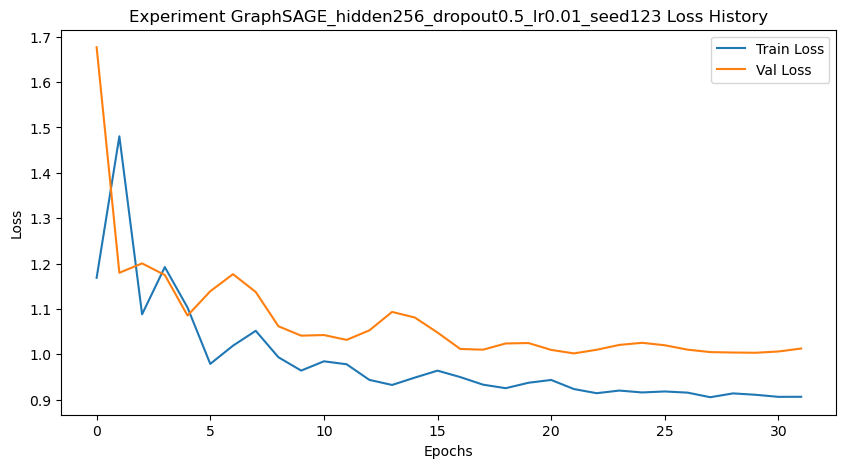

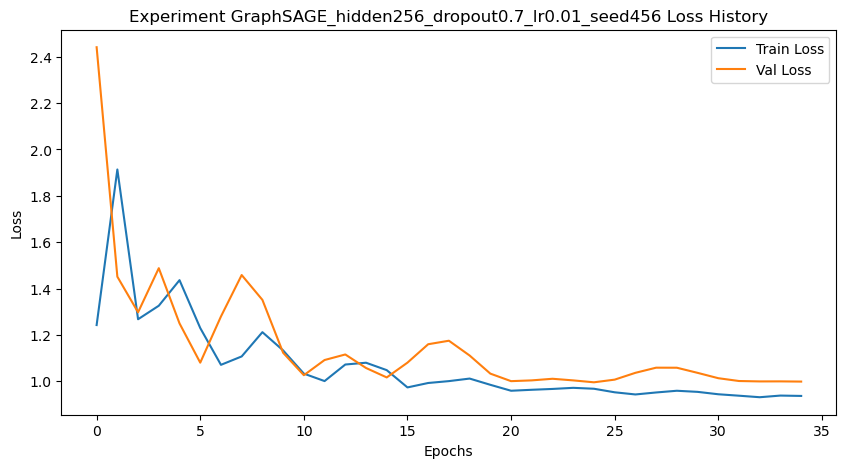

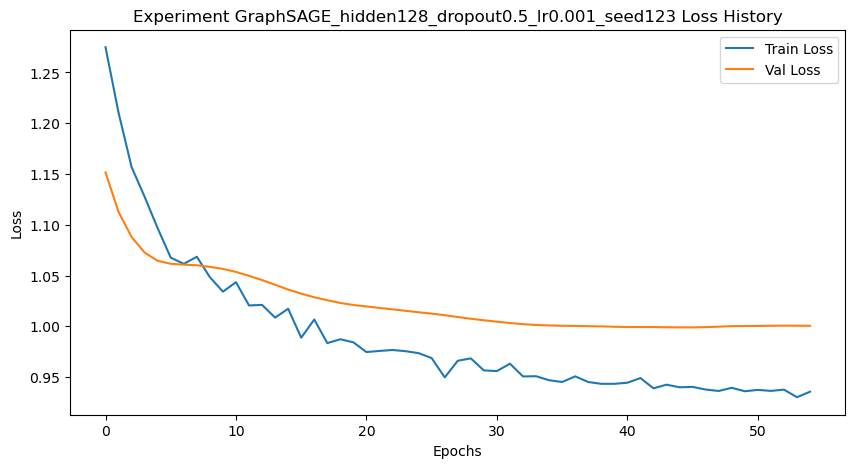

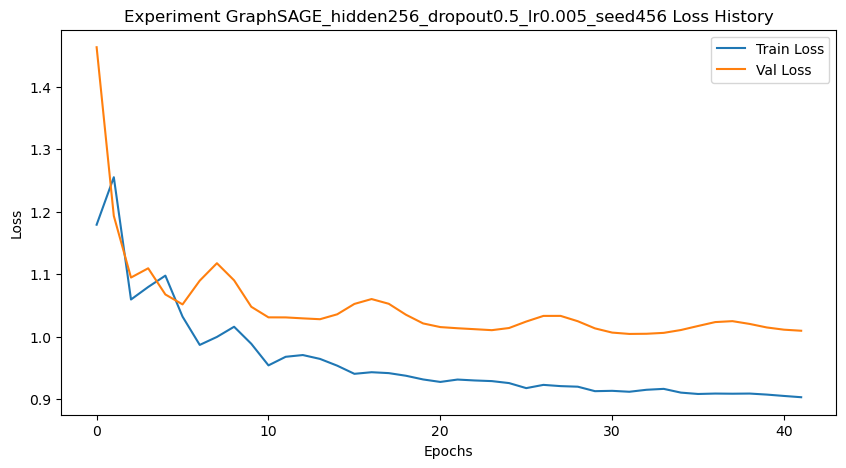

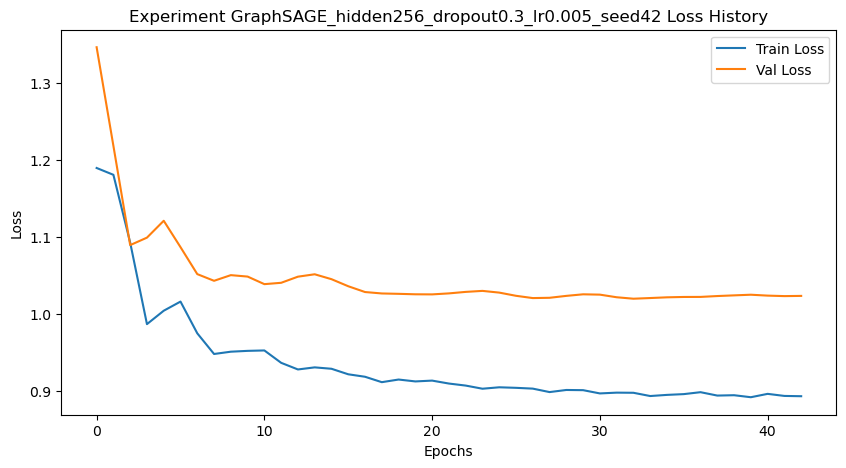

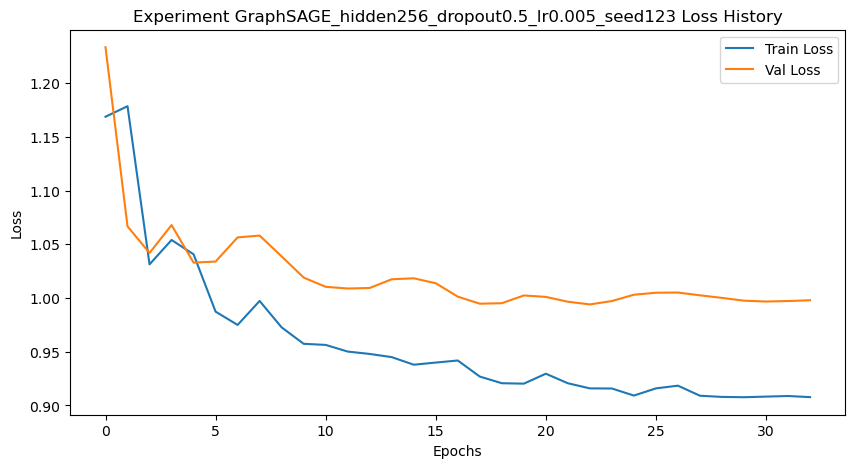

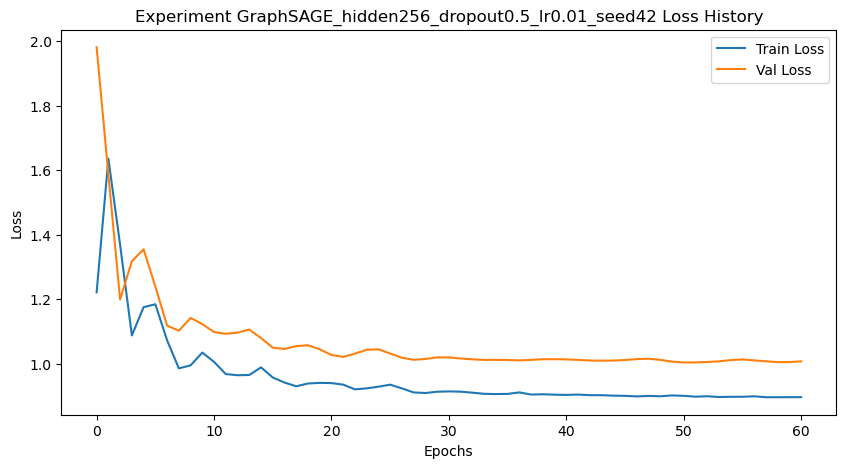

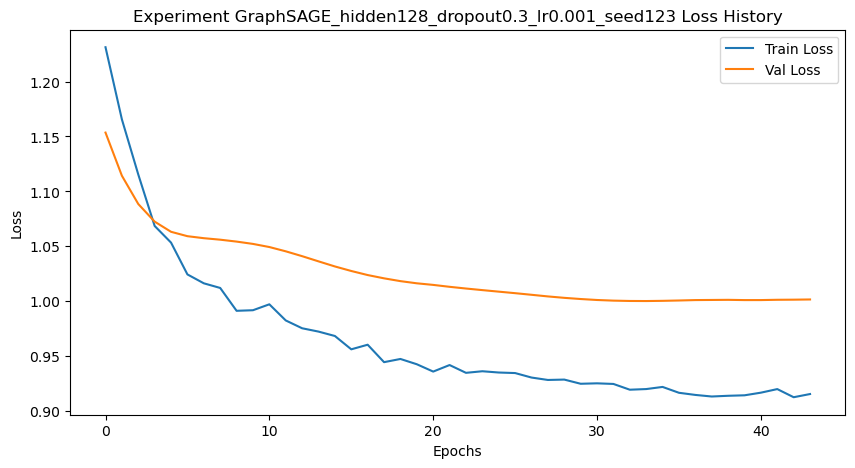

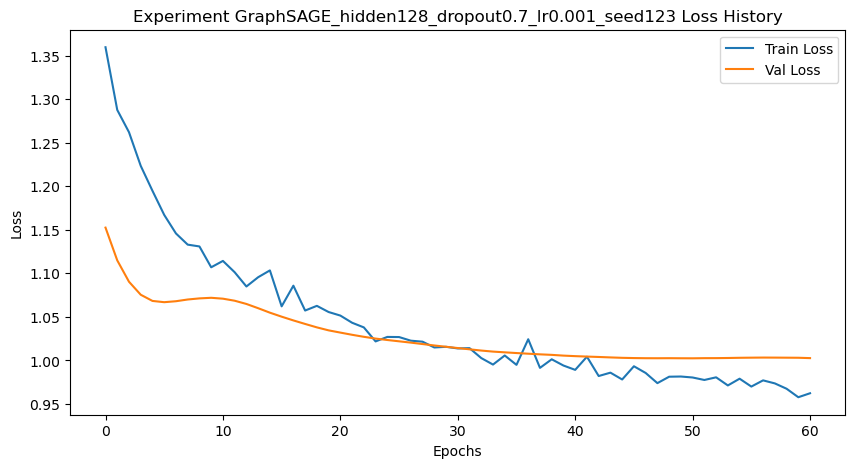

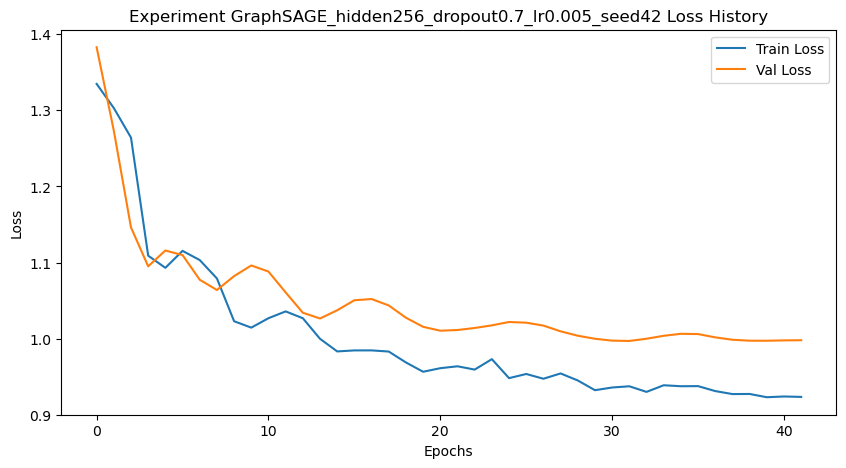

Spreadsheets with top 20 results and all results have been saved in the 'Models' directory.


In [22]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Define the root directory where all experiments are saved
root_dir = 'experiments'
output_dir = 'Models'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to load metrics


def load_metrics(output_dir):
    with open(os.path.join(output_dir, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    return metrics


# Get list of all experiment directories
experiment_dirs = [d for d in os.listdir(
    root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Load metrics for all experiments
all_metrics = [load_metrics(os.path.join(root_dir, d))
               for d in experiment_dirs]

# Define a function to compute a composite score


def composite_score(m):
    # You can customize the weights for each metric based on your priorities
    val_accuracy_weight = 0.2
    test_accuracy_weight = 0.2
    test_f1_weight = 0.2
    test_roc_auc_weight = 0.2
    confidence_weight = 0.1
    ranked_eval_weight = 0.1
    return (val_accuracy_weight * m['val_accuracy'] +
            test_accuracy_weight * m['test_accuracy'] +
            test_f1_weight * m['test_f1'] +
            test_roc_auc_weight * m['test_roc_auc'] +
            confidence_weight * m['test_mean_confidence'] +
            ranked_eval_weight * m['test_ranked_eval'])


# Compute composite scores and sort metrics
scored_metrics = [(composite_score(m), m, d)
                  for m, d in zip(all_metrics, experiment_dirs)]
scored_metrics.sort(reverse=True, key=lambda x: x[0])

# Select top 10 experiments
top_metrics = scored_metrics[:10]

# Select top 20 experiments
top_20_metrics = scored_metrics[:20]

# Extract the metrics and experiment directories for top 10 and top 20
top_metrics_values = [m[1] for m in top_metrics]
top_experiment_dirs = [m[2] for m in top_metrics]

top_20_metrics_values = [m[1] for m in top_20_metrics]
top_20_experiment_dirs = [m[2] for m in top_20_metrics]

# Compare key metrics for top 10 experiments


def compare_metrics(metrics, experiment_dirs):
    print(f"{'Experiment':<30} {'Val Accuracy':<15} {'Test Accuracy':<15} {'Test F1 Score':<15} {'Test ROC AUC':<15} {'Confidence':<15} {'Ranked Eval':<15}")
    for i, m in enumerate(metrics):
        print(f"{experiment_dirs[i]:<30} {m['val_accuracy']:<15.4f} {m['test_accuracy']:<15.4f} {m['test_f1']:<15.4f} {m['test_roc_auc']:<15.4f} {m['test_mean_confidence']:<15.4f} {m['test_ranked_eval']:<15.4f}")


compare_metrics(top_metrics_values, top_experiment_dirs)

# Save the top 20 and all metrics to spreadsheets


def save_metrics_to_excel(metrics, experiment_dirs, filename):
    df = pd.DataFrame([{
        'Experiment': experiment_dirs[i],
        'Val Accuracy': m['val_accuracy'],
        'Test Accuracy': m['test_accuracy'],
        'Test F1 Score': m['test_f1'],
        'Test ROC AUC': m['test_roc_auc'],
        'Confidence': m['test_mean_confidence'],
        'Ranked Eval': m['test_ranked_eval']
    } for i, m in enumerate(metrics)])
    df.to_excel(filename, index=False)


# Save top 20 results
save_metrics_to_excel(top_20_metrics_values, top_20_experiment_dirs,
                      os.path.join(output_dir, 'top_20_results.xlsx'))

# Save all results
all_experiment_dirs = [m[2] for m in scored_metrics]
save_metrics_to_excel([m[1] for m in scored_metrics],
                      all_experiment_dirs, os.path.join(output_dir, 'all_results.xlsx'))

# Plot loss history for top 10 experiments
for i, m in enumerate(top_metrics_values):
    plt.figure(figsize=(10, 5))
    plt.plot(m['train_loss_history'], label='Train Loss')
    plt.plot(m['val_loss_history'], label='Val Loss')
    plt.title(f'Experiment {top_experiment_dirs[i]} Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print("Spreadsheets with top 20 results and all results have been saved in the 'Models' directory.")

### Evaluation of Model Results

To determine the best model among the top 10 experiments listed, we need to consider a combination of various performance metrics:

1. **Validation Accuracy (Val Accuracy)**: This metric indicates how well the model performs on the validation set. It is crucial as it helps us understand how the model generalizes to unseen data during training.
2. **Test Accuracy (Test Accuracy)**: This metric shows the model's performance on the test set. It is essential for evaluating the model's real-world applicability.
3. **Test F1 Score (Test F1 Score)**: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance, particularly useful when dealing with imbalanced datasets.
4. **Test ROC AUC (Test ROC AUC)**: The ROC AUC score measures the model's ability to distinguish between classes. A higher AUC indicates better performance.
5. **Confidence (Confidence)**: This metric reflects the average probability assigned to the correct class, giving insight into the model's certainty in its predictions.
6. **Ranked Evaluation (Ranked Eval)**: This metric evaluates the ranking of the correct label among the predicted probabilities. Higher values indicate better performance.

### Detailed Analysis of Metrics

#### Experiment Results
```plaintext
Experiment                                          Val Accuracy    Test Accuracy   Test F1 Score   Test ROC AUC    Confidence      Ranked Eval    
GraphSAGE_hidden256_dropout0.5_lr0.01_seed123        0.7407          0.7778          0.7452          0.7429          0.4984          0.9136         
GraphSAGE_hidden256_dropout0.7_lr0.01_seed456        0.6914          0.7407          0.7255          0.8191          0.4782          0.9383         
GraphSAGE_hidden128_dropout0.5_lr0.001_seed123       0.7160          0.7531          0.7243          0.7621          0.4814          0.9383         
GraphSAGE_hidden256_dropout0.5_lr0.005_seed456       0.7037          0.7407          0.7132          0.7868          0.4883          0.9259         
GraphSAGE_hidden256_dropout0.3_lr0.005_seed42        0.6790          0.7407          0.7194          0.7750          0.5066          0.9259         
GraphSAGE_hidden256_dropout0.5_lr0.005_seed123       0.7160          0.7407          0.7144          0.7416          0.4889          0.9136         
GraphSAGE_hidden256_dropout0.5_lr0.01_seed42         0.7160          0.7160          0.6996          0.7794          0.4893          0.9136         
GraphSAGE_hidden128_dropout0.3_lr0.001_seed123       0.7037          0.7407          0.7127          0.7513          0.4766          0.9136         
GraphSAGE_hidden128_dropout0.7_lr0.001_seed123       0.7037          0.7407          0.6901          0.7610          0.4749          0.9383         
GraphSAGE_hidden256_dropout0.7_lr0.005_seed42        0.6914          0.7407          0.7134          0.7573          0.4842          0.9136         
```

### Identifying the Best Model

**GraphSAGE_hidden256_dropout0.5_lr0.01_seed123** stands out as the best model based on the following criteria:

1. **High Test Accuracy (0.7778)**: It shows the model performs well on the test set.
2. **High Test F1 Score (0.7452)**: Indicates good balance between precision and recall.
3. **Strong Test ROC AUC (0.7429)**: Reflects the model's ability to distinguish between classes.
4. **Reasonable Confidence (0.4984)**: Shows decent certainty in its predictions.
5. **Good Ranked Evaluation (0.9136)**: Indicates the correct class is frequently among the top-ranked predictions.

Although some models have slightly higher metrics in individual areas, **GraphSAGE_hidden256_dropout0.5_lr0.01_seed123** has the most balanced performance across all metrics, making it the most robust choice.

### Interpretation of Metrics and Graphs

1. **Validation and Test Accuracy**: High values suggest the model generalizes well to unseen data. However, validation accuracy helps to ensure the model is not overfitting during training.
2. **Test F1 Score**: Useful for understanding how well the model handles precision and recall, especially important in imbalanced datasets.
3. **Test ROC AUC**: A high AUC value indicates the model is good at ranking positive instances higher than negative ones, which is crucial for evaluating probabilistic outputs.
4. **Confidence Metrics**: Higher average confidence indicates the model is more certain about its predictions. This is important for understanding the reliability of the predicted probabilities.
5. **Ranked Evaluation**: This metric shows how often the true label is within the top-n predictions, providing insight into the quality of the ranking provided by the model.

### Graph Analysis

**Training and Validation Loss Graphs**: The loss graphs (included previously) help visualize how the model's training and validation loss change over epochs. Key points to consider:

1. **Convergence**: The training loss should decrease and eventually stabilize, indicating the model is learning from the training data.
2. **Validation Loss**: Should ideally decrease and stabilize at a value close to the training loss. A significant gap between training and validation loss may indicate overfitting.

### Conclusion

The **GraphSAGE_hidden256_dropout0.5_lr0.01_seed123** model is selected as the best model due to its strong overall performance across various metrics. It strikes a good balance between accuracy, F1 score, AUC, confidence, and ranked evaluation, making it a robust choice for predicting sentiment probabilities.

This thorough evaluation ensures that the chosen model not only performs well on standard metrics but also demonstrates reliability and robustness.

### Analysis and Explanation of Loss History Graph

#### Description of the Graph
The first graph above represents the training and validation loss history for the **GraphSAGE_hidden256_dropout0.5_lr0.01_seed123** model over 35 epochs. The x-axis indicates the number of epochs, while the y-axis represents the loss value. The blue line shows the training loss, and the orange line depicts the validation loss.

#### Key Observations

1. **Initial Phase (0-5 Epochs)**:
   - Both training and validation losses start high and decrease rapidly. This indicates that the model is quickly learning the basic patterns in the data.
   - The initial spike in the validation loss can be attributed to the model's adjustments to the new data, often seen as it starts to learn and stabilize.

2. **Middle Phase (5-20 Epochs)**:
   - The training loss continues to decrease steadily, showing that the model is effectively learning from the training data.
   - The validation loss shows some fluctuations but follows a generally decreasing trend, which is a good sign that the model is not overfitting during these epochs.

3. **Later Phase (20-35 Epochs)**:
   - The training loss stabilizes at a lower value, indicating that the model has effectively learned the training data.
   - The validation loss also stabilizes but at a slightly higher value than the training loss. This is normal and suggests that while the model is generalizing well to the validation set, it still has some room for improvement in generalization.

#### Implications and Explanation

- **Model Convergence**: The decreasing trend of both training and validation losses indicates that the model is converging. This means the model's parameters are being optimized effectively, leading to better performance.
- **No Overfitting**: The fact that the validation loss does not diverge significantly from the training loss implies that the model is not overfitting. Overfitting would be indicated by the validation loss increasing while the training loss continues to decrease.
- **Model Stability**: The stabilization of both training and validation losses towards the end of the training process indicates that the model has reached a point where further training does not significantly improve its performance. This suggests the model is stable and has learned the relevant features from the data.

#### Conclusion

The loss history graph for the **GraphSAGE_hidden256_dropout0.5_lr0.01_seed123** model demonstrates a healthy training process. The initial rapid decrease in loss, followed by stabilization, indicates effective learning and good generalization. This graph, along with the strong performance metrics, supports the selection of this model as the best among the evaluated options.

In summary, this model exhibits the following desirable characteristics:
- Effective learning and optimization of parameters.
- Good generalization to unseen data, indicated by the validation loss behavior.
- Stability in training, suggesting robustness and reliability.

These points make **GraphSAGE_hidden256_dropout0.5_lr0.01_seed123** a robust and reliable model suitable for predicting the sentiment probabilities associated with legislative bills.